<a href="https://colab.research.google.com/github/AmirJlr/Deep-Learning/blob/master/Intro_to_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""

Try to build a NN model to classify 3, 7


"""

'\n\nTry to build a NN model to classify 3, 7\n\n\n'

In [2]:
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book() # mount GDrive 
from fastbook import *
from matplotlib import pyplot as plt

We will work on a small subset of MNIST dataset which contains only two digits (3 and 7):

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/root/.fastai/data/mnist_sample')

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid')]

We can set the BASE_PATH to path so that we start from there and not the /root/.fastai...

In [5]:
Path.BASE_PATH = path

In [6]:
(path).ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [7]:
(path /"train").ls()

(#2) [Path('train/3'),Path('train/7')]

In [8]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

In [9]:
sevens
im7_path = sevens[54]
im7 = Image.open(im7_path)
im7

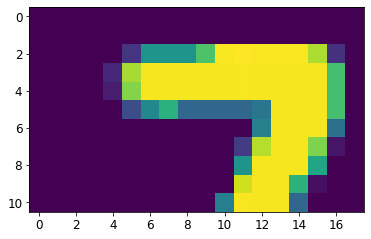

In [10]:
# --- We can convert PILImageFile to a numpy array or a tensor (on GPU):
# im7_array = array(im7)
# plt.imshow(im7_array)
im7_tensor = tensor(im7)
plt.imshow(im7_tensor[4:15, 4:22])

In [11]:
# --- We can also use pandas DF to vizualize them in a neat way:
df = pd.DataFrame(im7_tensor[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('BuPu')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,38,132,132,132,184,253,255,253,253,253,224,37,0
3,0,0,0,0,28,222,252,252,252,252,252,253,252,252,252,252,180,0
4,0,0,0,0,19,208,252,252,252,252,252,253,252,252,252,252,180,0
5,0,0,0,0,0,60,119,163,84,84,84,84,100,252,252,252,180,0
6,0,0,0,0,0,0,0,0,0,0,0,0,111,252,252,252,94,0
7,0,0,0,0,0,0,0,0,0,0,0,44,227,252,252,206,14,0
8,0,0,0,0,0,0,0,0,0,0,0,132,252,252,252,151,0,0
9,0,0,0,0,0,0,0,0,0,0,0,237,252,252,164,10,0,0


We will start by making a simple baseline predictive model (pixel similarity):

In [12]:
three_tensors = [tensor(Image.open(f)) for f in threes]
seven_tensors = [tensor(Image.open(f)) for f in sevens]


6265
torch.Size([28, 28])


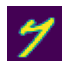

In [13]:
print(len(seven_tensors))
print(seven_tensors[1].shape)
show_image(seven_tensors[1])

Let's stack our images into a two tensors and normalize them:

In [14]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255



In [15]:
print(stacked_sevens.shape)
a_3 = stacked_threes[34]
a_7 = stacked_sevens[54]
a_3.shape

torch.Size([6265, 28, 28])


torch.Size([28, 28])

For this simple model, we will compare new images against the means of 3 and 7 tensors:


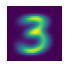

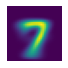

In [16]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

show_image(mean3), show_image(mean7);

In [17]:
 def img_distance(a, b):
     return (a - b).abs().mean()

print(img_distance(a_7, mean7))
print(img_distance(a_7, mean3))

tensor(0.1084)
tensor(0.1410)


In [18]:
(path / 'valid/7').ls()

(#1028) [Path('valid/7/7966.png'),Path('valid/7/2243.png'),Path('valid/7/9640.png'),Path('valid/7/1012.png'),Path('valid/7/1366.png'),Path('valid/7/4539.png'),Path('valid/7/9765.png'),Path('valid/7/243.png'),Path('valid/7/6050.png'),Path('valid/7/8837.png')...]

Let's create a validation set and a simple MAE fucntion:


In [19]:
# Stack tensors:
valid_3_tensors = torch.stack([tensor(Image.open(f)) for f in (path/'valid/3').ls()])
valid_7_tensors = torch.stack([tensor(Image.open(f)) for f in (path/'valid/7').ls()])

# Normalize tensors:
valid_3_tensors = valid_3_tensors.float()/255
valid_7_tensors = valid_7_tensors.float()/255

print(valid_3_tensors.shape)

torch.Size([1010, 28, 28])


In [20]:
def img_distance(input, mean_tensor): 
    return (input-mean_tensor).abs().mean((-1,-2))

def is_3(x): 
    return (img_distance(x, mean3) < img_distance(x, mean7)).float()


In [21]:
is_3(valid_3_tensors).shape

torch.Size([1010])

In [22]:
accuracy_3s = is_3(valid_3_tensors).mean()
accuracy_7s = (1 - is_3(valid_7_tensors)).mean()

print(accuracy_3s)
print(accuracy_7s)


tensor(0.9168)
tensor(0.9854)


In [23]:
print(len(stacked_threes))
print(len(stacked_sevens))
print(len(valid_3_tensors))
print(len(valid_7_tensors))

6131
6265
1010
1028


In [24]:
stacked_threes[62].shape

torch.Size([28, 28])

In [25]:
smaple_tensor = stacked_threes[62]
smaple_tensor_reshape = smaple_tensor.view(-1, 784)

In [26]:
smaple_tensor_reshape.shape

torch.Size([1, 784])

In [27]:
train_x = torch.cat([stacked_threes, stacked_sevens])

In [28]:
train_x.shape

torch.Size([12396, 28, 28])

In [29]:
train_x = train_x.view(-1,784)
train_x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [30]:
train_x.shape

torch.Size([12396, 784])

In [31]:
# ~ torch.cat([stacked_threes, stacked_sevens])

train_y = tensor([1] * len(stacked_threes) + [0] * len(stacked_sevens))

In [32]:
train_y.shape

torch.Size([12396])

In [33]:
train_y = train_y.unsqueeze(-1)

In [34]:
train_y.shape

torch.Size([12396, 1])

In [35]:
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1, 784)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(-1)

print(valid_x.shape, valid_y.shape)

torch.Size([2038, 784]) torch.Size([2038, 1])


In [36]:
# create dataset

dset = list(zip(train_x, train_y))

valid_dset = list(zip(valid_x, valid_y))

In [37]:
x, y = dset[93]

print(x.shape)
print(y)

torch.Size([784])
tensor([1])


In [38]:
dl = DataLoader(dset, batch_size= 256)

valid_dl = DataLoader(valid_dset, batch_size=256)

In [39]:
def init_params(size, std =1):
  return (torch.randn(size)*std).requires_grad_()


weights = init_params((784,1))
bias = init_params(1)

In [40]:
# batches 
len(list(dl))

49

In [41]:
print(list(dl)[19][0].shape)
print(list(dl)[19][1].shape)

torch.Size([256, 784])
torch.Size([256, 1])


In [42]:
sample_input = list(dl)[19][0][100]
sample_target = list(dl)[19][1][100]

In [43]:
sample_input.shape

torch.Size([784])

In [44]:
pred = sample_input @ weights + bias

sample_batch_pred = list(dl)[19][0] @ weights + bias

In [45]:
sample_batch_pred.shape

torch.Size([256, 1])

In [46]:
def linear1(x):
  return(x @ weights + bias)


In [47]:
preds = linear1(list(dl)[23][0])

preds.shape

torch.Size([256, 1])

In [48]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  predictions = (predictions > 0.5).float()

  return torch.where(targets == 1, 1-predictions, predictions).mean()

In [49]:
sample_input_batch = list(dl)[19][0]
sample_target_batch = list(dl)[19][1]

sample_preds_batch = linear1(sample_input_batch)

sample_error = mnist_loss(sample_preds_batch, sample_target_batch)
print(sample_error)

tensor(0.8203)


In [54]:
""" Full Model """

dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)


def init_params(size, std =1):
  return (torch.randn(size)*std).requires_grad_()


weights = init_params((784,1))
bias = init_params(1)
params = weights, bias


def linear1(x):
  return(x @ weights + bias)

def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  predictions = (predictions > 0.5).float()

  return torch.where(targets == 1, 1-predictions, predictions).mean()



def calc_grad(xb, yb, model):
  # 1. Claculate predictions using xb(input batch)
  # 2. Compute loss, using preds and yb(target batch)
  # 3. Compute derevitive of loss with respect to parametrs(backpropagation)
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

def train_epoch(model, lr, params):
  # Loop through all batches: for each, perform backpropagation
  # Update params(parameters), using SGD with learning rate = lr
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params :
      p.data -= p.grad * lr
      p.grad.zero_()

def batch_accuracy(xb_pred, yb):
  # Using a batch prediction(xb_pred) and its corresponding target(yb)
  # Calculate the batch accuracy (higher is better)
  preds = xb_pred.sigmoid()
  correct = (preds > 0.5) == yb

  return correct.float().mean()


def validate_epoch(model):
  # Calculate the mean accuracy over batches in the validation set.

  accs = [batch_accuracy(xb_pred, yb) for xb_pred, yb in valid_dl]
  
  return round(torch.stack(accs).mean().item(), 4)




In [55]:
validate_epoch(linear1)

0.5251

In [57]:

weights = init_params((784,1))
bias = init_params(1)
params = weights, bias


In [58]:
for ep in range(10):
  train_epoch(linear1, 0.5, params)
  print(validate_epoch(linear1))

RuntimeError: ignored